In [279]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Отключение некоторых лишних предупреждений
import warnings
warnings.filterwarnings("ignore")

# Часть 1: минималочка [макс 20 баллов]

В этой части мы с вами попробуем построить самую простую модель для предсказания.

Как мы с вами увидим: главная сложность - правильная подготовка данных. В таких задачах то, как именно вы преобразуете данные для обучения модели и будет во много определять её качество.

В этой части мы сделаем простое преобразование данных путём простой агрегации данных о величине транзакций. 

## Загрузка данных [5 баллов] 

Скачайте данные для задачи с Яндекс.Диска:
https://disk.yandex.ru/d/DGy6bbLaMZmrQg.

Загрузите файлы с транзакциями и целевой меткой в pd.DataFrame.

__Внимание__: у файла transactions.csv колоночный разделитель - точка с запятой ";"

In [280]:
transactions = pd.read_csv('transactions.csv', sep = ';')
transactions

,user_id,dt,type,value
0,39026145,0 10:23:26,"Звонки с использованием телефонов, считывающих...",2695.099
1,39026145,6 07:08:31,"Звонки с использованием телефонов, считывающих...",2358.212
2,39026145,8 07:06:10,"Звонки с использованием телефонов, считывающих...",2807.395
3,39026145,11 08:49:03,"Звонки с использованием телефонов, считывающих...",2695.099
4,39026145,11 14:12:08,"Звонки с использованием телефонов, считывающих...",2695.099
...,...,...,...,...
2282462,71902723,290 15:12:09,Агенты и менеджеры по аренде недвижимости,2133.620
2282463,71942984,248 00:00:00,Агенты и менеджеры по аренде недвижимости,1870.848
2282464,71942984,375 00:00:00,Агенты и менеджеры по аренде недвижимости,2466.016
2282465,74289663,27 00:00:00,Агентства по аренде автомобилей,1445.831


In [281]:
gender = pd.read_csv('gender.csv')
gender

,user_id,gender
0,6740969,1.0
1,36599781,0.0
2,91453656,1.0
3,17431962,1.0
4,72568668,1.0
...,...,...
8395,93715144,1.0
8396,51502229,0.0
8397,77655748,1.0
8398,87819773,1.0


## Подготовка данных [10 баллов] 

Для данной задачи необходимо как-то собрать данные для каждого пользователя в один вектор (строку таблицы). Сейчас, как вы можете увидеть, в таблице с данными одному пользователю может соответствовать много строк (каждая операция - отдельная строка).

Таким образом, необходима агрегация данных - это можно сделать множеством разных способов.

### Агрегация 

Произведите простую агрегацию данных и для каждого пользователя в качестве признаков получите сумму, среднее и стандартное отклонение величины его транзакций. 

Так же добавите для каждого пользователя колонку с таргетом.

По итогу вы должны получить таблицу с колонками:
* user_id
* value_sum
* value_mean
* value_std
* gender

In [282]:
# делаем агрегацию данных
df = pd.DataFrame
u = transactions.groupby('user_id').sum()
u.reset_index(inplace = True)
u.rename(columns = {'value':'value_sum'}, inplace = True)

m =  transactions.groupby('user_id').mean()
m.reset_index(inplace = True)
m.rename(columns = {'value':'value_mean'}, inplace = True)

um = pd.merge(u, m, how = 'right', on = 'user_id')

s = transactions.groupby('user_id').std()
s.reset_index(inplace = True)
s.rename(columns = {'value':'value_std'}, inplace = True)

ums = pd.merge(um, s, how = 'right', on = 'user_id')

umsg = pd.merge(ums, gender, how = 'left', on = 'user_id')
df = umsg

df = df.set_index('user_id')
df

,value_sum,value_mean,value_std,gender
user_id,,,,
22899,274383.315,2143.619648,656.186785,1.0
27914,166436.523,2521.765500,415.972053,1.0
28753,251578.185,1980.930591,749.304999,0.0
31385,717856.052,2323.158744,632.491585,0.0
38084,1360028.958,2095.576206,649.030870,0.0
...,...,...,...,...
99953525,159252.786,1608.614000,709.903466,0.0
99967537,13026.313,2605.262600,123.013557,1.0
99988578,1304612.429,2185.280451,638.235664,1.0


### Отложенная выборка 

Получите полный список пользователей и разделите их на два списка:
* тренировочный список пользователей (80%)
* тестовый список пользователей (20%)

__Важное замечание__: Далее во всех пунктах, где вам нужно провалидировать (оценить) получившуюся модель исползуйте данные только для этих тестовых пользователей.

Обучать все модели, естественно, нужно только на данных пользователей из обучающего списка.

Для нашей задачи получите признаки и целевые метки обучающей и тестовой выборки. 

In [283]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['gender'], random_state = 34)

y_train = df_train['gender']
y_test = df_test['gender'] 
X_train = df_train.drop('gender', axis=1)
X_test = df_test.drop('gender', axis=1)


In [284]:
X_train.isnull().sum()

value_sum      0
value_mean     0
value_std     42
dtype: int64

In [285]:
X_test.isnull().sum()

value_sum     0
value_mean    0
value_std     5
dtype: int64

In [286]:
X_test['value_std'] = X_test['value_std'].fillna(0)
X_train['value_std'] = X_train['value_std'].fillna(0)

## Обучение и оценка модели [5 баллов] 

Обучите модель логистической регрессии с дефолтными параметрами.

Получите предсказания вероятностей первого класса.

In [287]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train);

p_pred = model.predict_proba(X_test)
p_pred #вторая колонка - это предсказания вероятностей первого класса

array([[0.54828744, 0.45171256],
       [0.64274727, 0.35725273],
       [0.55290429, 0.44709571],
       ...,
       [0.57419634, 0.42580366],
       [0.57068464, 0.42931536],
       [0.58622235, 0.41377765]])

In [288]:
p_pred = p_pred[:, -1]

In [289]:
p_pred #вероятности первого класса

array([0.45171256, 0.35725273, 0.44709571, ..., 0.42580366, 0.42931536,
       0.41377765])

In [290]:
y_pred = model.predict(X_test)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

### Валидация 

Посчитайте ROC_AUC, accuracy, precision, recall для получившихся предсказаний.

Для метрик, для которых необходимы метки классов, а не вероятности - используйте порог 0.5.

Далее при оценки других моделей приводите эти же метрики (если явно не указано иное).

In [291]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy_score(y_pred, y_test), precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.5604066985645934, 0.5846153846153846, 0.05093833780160858)

In [292]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def roc_auc_pic(y_test, p_pred):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, p_pred)
    roc_auc_test = roc_auc_score(y_test, p_pred)

    plt.figure(figsize=(7, 7))
    plt.plot(fpr_test, tpr_test, label='Test ROC-AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right');

In [293]:
roc_auc_score(y_test, p_pred)

0.5512278588758476

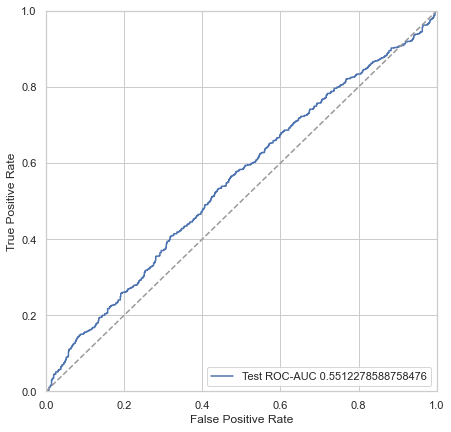

In [294]:
roc_auc_pic(y_test, p_pred)

### Вывод

Как вы оцениваете качество получившейся модели и возможные причины такого качества?

__Ваш вывод:__ качество модели оставляет желать лучшего, так как точность равна 0.58, то есть всего с вероятностью 0.58 мы можем доверять алгоритму, если он предсказал 1. ROC_AUC = 0.55, что говорит о низкой доле правильно предсказанных объектов.

# Часть 2: мб сделаем что-то более серьёзное? [макс 20 баллов]

Давайте попробуем улучшить качество решения задачи за счёт другого метода подготовки данных.

Ранее мы использовали простое преобразование, когда каждый клиент описывался только 3 значениями.
Давайте сделаем что-то более сложное и попробуем добавить больше данных о клиенте для модели.

## Подготовка данных [15 баллов]

Воспользуемся тем, что каждая транзакция у нас имеет свой тип - это уж точно более информативно, чем агрегация по всем транзакциям.

Создайте сводную таблицу, где для каждого клиента (строка) будут указаны его суммарные траты на каждую категорию (столбец). Таким образом, вы должны получить таблицу с числом строк равным количеству клиентов и числом столбцов - количеству категорий трат. Каждая ячейка должна содержать суммарные траты данного клиента в данной категории.

__Подсказка__: у DataFrame есть полезный метод `pivot_table`.

In [295]:
pivot = pd.pivot_table(transactions, index = 'user_id', columns="type", values='value', aggfunc='sum', fill_value=0)
pivot = pd.merge(pivot, gender, how = 'left', on = 'user_id')
pivot = pivot.set_index('user_id')
pivot

,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,Агенты и менеджеры по аренде недвижимости,...,"Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование,gender
user_id,,,,,,,,,,,,,,,,,,,,,
22899,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0
27914,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0
28753,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
31385,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
38084,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99953525,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
99967537,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0
99988578,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4267.24,0.0,0.0,0.0,0.0,1.0


## Обучение и валидация модели [5 баллов]

Аналогично предыдущей части разделите данные на обучающую и тестовую выборку (80%/20%), обучите модель на дефолтных параметрах и оцените качество.

In [296]:
df_train, df_test = train_test_split(pivot, test_size=0.2, stratify=df['gender'], random_state = 34)
y_train = df_train['gender']
y_test = df_test['gender'] 
X_train = df_train.drop('gender', axis=1)
X_test = df_test.drop('gender', axis=1)

model = LogisticRegression()
model.fit(X_train, y_train);

p_pred = model.predict_proba(X_test)
p_pred #предсказание вероятностей 0 и 1 класса соответственно

array([[0.58518321, 0.41481679],
       [0.44349698, 0.55650302],
       [0.30092486, 0.69907514],
       ...,
       [0.5590469 , 0.4409531 ],
       [0.7409857 , 0.2590143 ],
       [0.34260809, 0.65739191]])

In [297]:
y_pred = model.predict(X_test)
y_pred

array([0., 1., 1., ..., 0., 0., 1.])

In [298]:
accuracy_score(y_pred, y_test), precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.715311004784689, 0.7027027027027027, 0.6273458445040214)

In [299]:
roc_auc_score(y_test, p_pred[:, -1])

0.7821006491062485

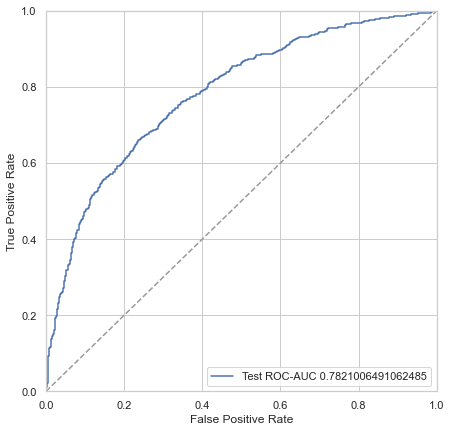

In [300]:
roc_auc_pic(y_test, p_pred[:, -1])

### Вывод

Видим, что по сравнению с предыдущей моделью качество предсказания улучшилось. Теперь доля правильно предсказанных значений составляет 0.78, а точность 0.7. 
Качество модели изменилось, оптому что мы предварительно сделали более приемлемую для задачи классификации обработку данных.

# Часть 3: что мы всё про данные? Давайте про модель 
# [макс 30 баллов]

Ранее мы работали только над подготовкой обучающей выборки. Давайте теперь попробуем изменить модель, чтобы добиться наилучшего качества. 

Входные данные для этой части - выборка с предыдущей.

## Нормирование данных [5 баллов] 

Как мы знаем, линейные модели любят нормированные данные.

Приведите значения всех признаков в отрезок [0, 1]

__Замечание__: если вы используете метод, который удаляет информацию о названиях колонок - сохраните эти названия в отдельную переменную, вам это потом может понадобиться.

In [301]:
pivot

,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,Агенты и менеджеры по аренде недвижимости,...,"Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование,gender
user_id,,,,,,,,,,,,,,,,,,,,,
22899,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0
27914,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0
28753,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
31385,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
38084,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99953525,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
99967537,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0
99988578,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4267.24,0.0,0.0,0.0,0.0,1.0


In [302]:
pivot0 = pivot.drop('gender', axis = 1) 
pivot0

,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,Агенты и менеджеры по аренде недвижимости,...,"Фотостудии, фотолаборатории","Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование
user_id,,,,,,,,,,,,,,,,,,,,,
22899,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
27914,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
28753,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
31385,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
38084,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99953525,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
99967537,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
99988578,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4267.24,0.0,0.0,0.0,0.0


In [303]:
numeric_features = pivot0.columns
numeric_features

Index(['Авиалинии, авиакомпании',
       'Авиалинии, авиакомпании, нигде более не классифицированные',
       'Автобусные линии', 'Автозапчасти и аксессуары',
       'Автоматизированные бензозаправки', 'Автомойки', 'Автошины',
       'Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка',
       'Агентства по аренде автомобилей',
       'Агенты и менеджеры по аренде недвижимости',
       ...
       'Фотостудии, фотолаборатории',
       'Химикалии и смежные вещества, не классифицированные ранее',
       'Химчистки', 'Ценные бумаги: брокеры/дилеры', 'Центры здоровья',
       'Цифровые товары, игры', 'Школы — бизнес и секретарей', 'Штрафы',
       'Штучные товары, галантерея и другие текстильные товары',
       'Электрические части и оборудование'],
      dtype='object', length=184)

In [304]:
user_id = pivot.index
user_id

Int64Index([   22899,    27914,    28753,    31385,    38084,    42096,
               50940,    52926,    53395,    70680,
            ...
            99876778, 99877835, 99882949, 99900908, 99918216, 99953525,
            99967537, 99988578, 99991245, 99999680],
           dtype='int64', name='user_id', length=8356)

In [305]:
pivot[numeric_features]

,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,Агенты и менеджеры по аренде недвижимости,...,"Фотостудии, фотолаборатории","Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование
user_id,,,,,,,,,,,,,,,,,,,,,
22899,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
27914,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
28753,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
31385,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
38084,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99953525,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
99967537,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
99988578,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4267.24,0.0,0.0,0.0,0.0


In [306]:
from sklearn.preprocessing import StandardScaler #отскалируем (нормализуем) данные 

scaler = StandardScaler()

#X_train_scale = scaler.fit_transform(X_train)
pivot1 = scaler.fit_transform(pivot[numeric_features])
pivot_sd = pd.DataFrame(pivot1, columns = numeric_features)

In [307]:
pivot_sd

,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,Агенты и менеджеры по аренде недвижимости,...,"Фотостудии, фотолаборатории","Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование
0,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144
1,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144
2,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144
3,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144
4,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8351,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144
8352,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144
8353,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,3.014278,-0.02247,-0.074599,-0.05968,-0.057144
8354,-0.038378,-0.111804,-0.054764,0.345254,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144


In [308]:
pivot_sd = pivot_sd.set_index(user_id)
pivot_sd

,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,Агенты и менеджеры по аренде недвижимости,...,"Фотостудии, фотолаборатории","Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование
user_id,,,,,,,,,,,,,,,,,,,,,
22899,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144
27914,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144
28753,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144
31385,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144
38084,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99953525,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144
99967537,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144
99988578,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.050882,-0.052629,-0.052989,-0.029353,-0.095547,3.014278,-0.02247,-0.074599,-0.05968,-0.057144


In [309]:
pivot['gender']

user_id
22899       1.0
27914       1.0
28753       0.0
31385       0.0
38084       0.0
           ... 
99953525    0.0
99967537    1.0
99988578    1.0
99991245    1.0
99999680    1.0
Name: gender, Length: 8356, dtype: float64

In [310]:
pivot_sd1 = pd.merge(pivot_sd, pivot['gender'], how = 'right', on = 'user_id')
pivot_sd1

,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,Агенты и менеджеры по аренде недвижимости,...,"Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование,gender
user_id,,,,,,,,,,,,,,,,,,,,,
22899,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144,1.0
27914,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144,1.0
28753,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144,0.0
31385,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144,0.0
38084,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99953525,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144,0.0
99967537,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.052629,-0.052989,-0.029353,-0.095547,-0.064286,-0.02247,-0.074599,-0.05968,-0.057144,1.0
99988578,-0.038378,-0.111804,-0.054764,-0.209355,-0.056654,-0.111879,-0.061411,-0.02846,-0.01094,-0.019957,...,-0.052629,-0.052989,-0.029353,-0.095547,3.014278,-0.02247,-0.074599,-0.05968,-0.057144,1.0


Отскалировали данные по Х: Сделали отдельную табличку с признаками, а потом добавили y. 

In [311]:
df_train, df_test = train_test_split(pivot_sd1, test_size=0.2, stratify=df['gender'], random_state = 31)
y_train = df_train['gender']
y_test = df_test['gender'] 
X_train = df_train.drop('gender', axis=1)
X_test = df_test.drop('gender', axis=1)

## Подбор параметров [15 баллов]

Подберите наилучшие параметры для модели линейной регрессии. Важные уточнения:

* используйте перебор по сетке
* в качестве метрики используйте ROC AUC
* для оценки параметров делайте кросс-валидацию на 4 фолдах

__Замечание__: у линейной регрессии множество доступных значений для некоторых параметров зависит от метода оптимизации (solver). Например, lbfgs-алгоритм не подерживает l1-регуляризацию.

Поэтому действуйте шагами: сначала подберите solver, а потом уже переберите доступные для него параметры.

In [313]:
# https://ru.stackoverflow.com/questions/1446637/%d0%9f%d0%be%d0%b4%d0%b1%d0%be%d1%80-%d0%bf%d0%b0%d1%80%d0%b0%d0%bc%d0%b5%d1%82%d1%80%d0%be%d0%b2-%d0%b4%d0%bb%d1%8f-%d0%bb%d0%be%d0%b3%d0%b8%d1%81%d1%82%d0%b8%d1%87%d0%b5%d1%81%d0%ba%d0%be%d0%b9-%d1%80%d0%b5%d0%b3%d1%80%d0%b5%d1%81%d1%81%d0%b8%d0%b8
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
model = LogisticRegression(random_state=23)
#C = np.logspace(-4,4,50)
#Solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid_clf = GridSearchCV(model, parameters, cv=4, scoring='roc_auc')
grid_clf.fit(X_train, y_train)

print(grid_clf.best_estimator_)
print(grid_clf.best_params_)
print(grid_clf.best_score_)

LogisticRegression(random_state=23, solver='saga')
{'solver': 'saga'}
0.789807441489747


In [314]:
model = LogisticRegression(solver = 'saga', random_state = 23)
#C = np.logspace(-4,4,50)
#Solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
parameters = {'C': np.logspace(-4,4,50), 'penalty': ['l1', 'l2']}
grid_clf = GridSearchCV(model, parameters, cv=4, scoring='roc_auc')
grid_clf.fit(X_train, y_train)

print(grid_clf.best_estimator_)
print(grid_clf.best_params_)
print(grid_clf.best_score_)

LogisticRegression(C=0.040949150623804234, penalty='l1', random_state=23,
                   solver='saga')
{'C': 0.040949150623804234, 'penalty': 'l1'}
0.8033644301137599


Получили оптимальные параметры для логистической регрессии. Теперь обучим модель, используя эти параметры.

In [315]:
model = LogisticRegression(solver = 'saga', C = 0.040949150623804234, penalty= 'l1', random_state=23)
model.fit(X_train, y_train)

p_pred = model.predict_proba(X_test)
p_pred

array([[9.70487871e-01, 2.95121286e-02],
       [9.99927209e-01, 7.27908906e-05],
       [5.51994116e-01, 4.48005884e-01],
       ...,
       [7.63576034e-01, 2.36423966e-01],
       [6.85330656e-01, 3.14669344e-01],
       [4.04964195e-01, 5.95035805e-01]])

In [316]:
y_pred = model.predict(X_test)
y_pred

array([0., 0., 0., ..., 0., 0., 1.])

In [317]:
accuracy_score(y_pred, y_test), precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.72188995215311, 0.7896907216494845, 0.5134048257372654)

In [318]:
roc_auc_score(y_test, p_pred[:, -1])

0.811421172097117

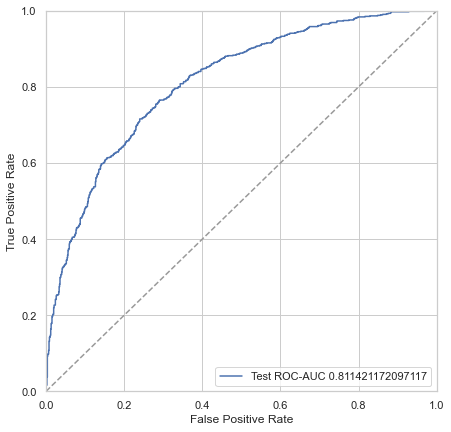

In [319]:
roc_auc_pic(y_test, p_pred[:, -1])

Получилось ли добиться лучше качества при подборе параметров?
Почему так? 

Для чего мы использовали одновременно кросс-валидацию и отложенную тестовую выборку?

__Ваш вывод__: Качество стало лучше, потому что новые параметры были подобраны специально под конкретные данные, а не использовались те, что по умолчанию. 
    
Кросс-валидация и отложенная тастовая выборка использовались вместе, чтобы модель "не видела" все данные и мы могли точнее оценить ее качество. То есть X_test, y_test модель увидела только после обучения на трейне и на валидационной выборке, а оценка качества проводилась на y_pred и y_test.

## Подбор отсечения [5 баллов]

Ранее мы работали или с вероятностями из модели или с метками, полученных при отсечении по веростности с порогом 0.5.

Стоит сказать, что порог 0.5 для разделения классов не всегда самый лучший. Часто нам нужно так подобрать порог, чтобы удовлетворить наши требования по точности и полноте.

Давайте подберём порог, который максимизирует F_beta меру при условии, что нам полнота в 5 раз важнее точности.

Вычислите наилучший порог и нарисуйте график зависимости этой метрики от порога разделения.

In [320]:
p_pred = p_pred[:, -1]

In [321]:
from sklearn.metrics import fbeta_score

all_t = []
all_Fb = []

#t = 0.1*k
for k in range(0, 11):
    t = 0.1*k
    y_pred = 1*(p_pred >= t) 
    print(y_pred)
    print(f'for {t}: Точность: {precision_score(y_test, y_pred)}, Полнота: {recall_score(y_test, y_pred)}, F_beta: {fbeta_score(y_test, y_pred, 5/6)}')
    all_t.append(t)
    all_Fb.append(fbeta_score(y_test, y_pred, 5/6))
    

[1 1 1 ... 1 1 1]
for 0.0: Точность: 0.4461722488038278, Полнота: 1.0, F_beta: 0.577179675807311
[0 0 1 ... 1 1 1]
for 0.1: Точность: 0.47652733118971063, Полнота: 0.9932975871313673, F_beta: 0.6056679619455984
[0 0 1 ... 1 1 1]
for 0.2: Точность: 0.5, Полнота: 0.9758713136729222, F_beta: 0.6248839107308699
[0 0 1 ... 0 1 1]
for 0.30000000000000004: Точность: 0.5345345345345346, Полнота: 0.9544235924932976, F_beta: 0.6521125491726977
[0 0 1 ... 0 0 1]
for 0.4: Точность: 0.6160458452722063, Полнота: 0.8646112600536193, F_beta: 0.6983245181214724
[0 0 0 ... 0 0 1]
for 0.5: Точность: 0.7896907216494845, Полнота: 0.5134048257372654, F_beta: 0.6469952921628358
[0 0 0 ... 0 0 0]
for 0.6000000000000001: Точность: 0.8390092879256966, Полнота: 0.3632707774798928, F_beta: 0.5459739745029395
[0 0 0 ... 0 0 0]
for 0.7000000000000001: Точность: 0.8654708520179372, Полнота: 0.2587131367292225, F_beta: 0.44129994752230306
[0 0 0 ... 0 0 0]
for 0.8: Точность: 0.910958904109589, Полнота: 0.178284182305

In [322]:
all_t

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

In [323]:
all_t[all_Fb.index(max(all_Fb))] #порог отсечения, максимизирующий F_beta

0.4

Text(0.5, 1.0, 'Зависимость F_beta от порога отсечения')

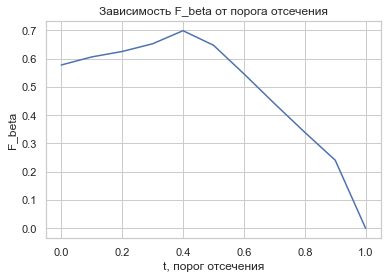

In [324]:
plt.plot(all_t, all_Fb)
plt.xlabel('t, порог отсечения')
plt.ylabel('F_beta')
plt.title('Зависимость F_beta от порога отсечения')

## Интерпретация модели [5 баллов]

Часто нам хочется интерпритировать предсказания модели - понять, как наши признаки влияют на её ответ.
В случае сложных моделей сделать это не просто - чем сложнее модель, тем более сложные закономерности она извлекает и тем тяжелее нам их понять.

Но в случае линейной регресии это просто сделать, посмотрев на её обучаемые параметры (вспоминайте!).

Получите список признаков, которые увеличивают вероятность метки 0.
Аналогично для метки 1.

In [325]:
coefs = list(model.coef_[0])

In [326]:
coefs

[0.03413370188750116,
 0.0,
 0.0,
 0.5362390926962148,
 0.01867305829229537,
 0.04582284270835471,
 0.01596121778550845,
 -0.009301314385805004,
 0.018767493741262166,
 -0.017437002527605428,
 -0.20513266211739112,
 -0.3834381162342688,
 -0.0019780237272311253,
 0.12486904166453194,
 0.0959696186936509,
 0.007418712629083874,
 0.0,
 0.02705904622143285,
 0.0,
 0.0,
 0.0,
 0.0001314455176107172,
 0.0,
 -0.02553622289865499,
 0.013435711098436064,
 0.0,
 0.2914665045037356,
 0.015663112859227103,
 0.08796469224661735,
 -0.3881348932982294,
 -0.03220232959255898,
 -0.07895112201845585,
 0.008030273599875876,
 0.013074515451292287,
 0.0,
 0.0,
 0.0036334562555180427,
 0.0,
 0.018088524492995018,
 -0.23373737312957296,
 -0.04295874614003827,
 -0.02885095083453909,
 -0.07037776371349806,
 0.0,
 0.01600202007915486,
 0.04808078225347503,
 0.010654445744984323,
 0.22288800950908802,
 0.0030024134603583922,
 0.0,
 0.002762868839721199,
 0.0,
 0.0,
 0.09574697442393242,
 0.049427103532530194,
 0

In [327]:
features_num = list(numeric_features)

Выше приведены коэффициенты модели и список из признаков Х. Посмотрим, как признаки влияют на вероятность метки 0 или 1. Если коэффициент отрицательный, то он увеличивает вероятность 0, если положительный - то увеличивает вероятность 1.

In [328]:
positive = {}
negative = {}
for i in coefs:
    if i > 0:
        positive[features_num[coefs.index(i)]] = i
    elif i < 0:
        negative[features_num[coefs.index(i)]] = i

In [329]:
positive

{'Авиалинии, авиакомпании': 0.03413370188750116,
 'Автозапчасти и аксессуары': 0.5362390926962148,
 'Автоматизированные бензозаправки': 0.01867305829229537,
 'Автомойки': 0.04582284270835471,
 'Автошины': 0.01596121778550845,
 'Агентства по аренде автомобилей': 0.018767493741262166,
 'Бакалейные магазины, супермаркеты': 0.12486904166453194,
 'Бары, коктейль-бары, дискотеки, ночные клубы и таверны — места продажи алкогольных напитков': 0.0959696186936509,
 'Беспошлинные магазины Duty Free': 0.007418712629083874,
 'Билльярд-клубы': 0.02705904622143285,
 'Бытовое оборудование': 0.0001314455176107172,
 'Видеопрокат': 0.013435711098436064,
 'Галереи/учреждения видеоигр': 0.2914665045037356,
 'Генеральные подрядчики по вентиляции, теплоснабжению, и водопроводу': 0.015663112859227103,
 'Горючее топливо — уголь, нефть, разжиженный бензин, дрова': 0.08796469224661735,
 'Денежные переводы MasterCard MoneySend': 0.008030273599875876,
 'Детская одежда, включая одежду для самых маленьких': 0.013074

In [330]:
negative

{'Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка': -0.009301314385805004,
 'Агенты и менеджеры по аренде недвижимости': -0.017437002527605428,
 'Аксессуары для женщин': -0.20513266211739112,
 'Аптеки': -0.3834381162342688,
 'Ассоциации — гражданские, социальные и братские': -0.0019780237272311253,
 'Ветеринарные услуги': -0.02553622289865499,
 'Готовая женская одежда': -0.3881348932982294,
 'Дантисты, ортодонтисты': -0.03220232959255898,
 'Денежные переводы': -0.07895112201845585,
 'Звонки с использованием телефонов, считывающих магнитную ленту': -0.23373737312957296,
 'Зоомагазины': -0.04295874614003827,
 'Зубные и медицинские лаборатории': -0.02885095083453909,
 'Изготовление и продажа меховых изделий': -0.07037776371349806,
 'Лекарства, их распространители, аптеки': -0.08117180316935858,
 'Луна-парки, карнавалы, цирки, предсказатели будущего': -0.006524340293961881,
 'Магазины косметики': -0.416919918082

In [331]:
positive_feature = list(positive.keys())
negative_feature = list(negative.keys())
 

In [332]:
positive_feature #список признаков, которые увеличивают вероятность метки 1

['Авиалинии, авиакомпании',
 'Автозапчасти и аксессуары',
 'Автоматизированные бензозаправки',
 'Автомойки',
 'Автошины',
 'Агентства по аренде автомобилей',
 'Бакалейные магазины, супермаркеты',
 'Бары, коктейль-бары, дискотеки, ночные клубы и таверны — места продажи алкогольных напитков',
 'Беспошлинные магазины Duty Free',
 'Билльярд-клубы',
 'Бытовое оборудование',
 'Видеопрокат',
 'Галереи/учреждения видеоигр',
 'Генеральные подрядчики по вентиляции, теплоснабжению, и водопроводу',
 'Горючее топливо — уголь, нефть, разжиженный бензин, дрова',
 'Денежные переводы MasterCard MoneySend',
 'Детская одежда, включая одежду для самых маленьких',
 'Дорожный и мостовой сборы, пошлины',
 'Жилье — отели, мотели, курорты',
 'Информационные провайдеры',
 'Кабельные и другие платные телевизионные услуги',
 'Канцелярия, офисные сопутствующие товары, бумага для печатания и письма',
 'Кинотеатры',
 'Клубы — сельские клубы, членство(спортивный, отдых, спорт), частные поля для гольфа',
 'Книжные маг

In [333]:
negative_feature #список признаков, которые увеличивают вероятность метки 0

['Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка',
 'Агенты и менеджеры по аренде недвижимости',
 'Аксессуары для женщин',
 'Аптеки',
 'Ассоциации — гражданские, социальные и братские',
 'Ветеринарные услуги',
 'Готовая женская одежда',
 'Дантисты, ортодонтисты',
 'Денежные переводы',
 'Звонки с использованием телефонов, считывающих магнитную ленту',
 'Зоомагазины',
 'Зубные и медицинские лаборатории',
 'Изготовление и продажа меховых изделий',
 'Лекарства, их распространители, аптеки',
 'Луна-парки, карнавалы, цирки, предсказатели будущего',
 'Магазины косметики',
 'Магазины мужской и женской одежды',
 'Магазины офисных, школьных принадлежностей, канцтоваров',
 'Магазины по продаже часов, ювелирных изделий и изделий из серебра',
 'Магазины ткани, ниток рукоделия, шитья',
 'Магазины хрусталя и изделий из стекла',
 'Магазины художественных и ремесленных изделий',
 'Магазины, торгующие по сниженным ценам',
 '

# Часть 4: ва-банк / пространство для творчества [макс 30 баллов]

Добейтесь максимального качества, больше качество - больше баллов.
​
Стратегия подготовки данных и обучения модели на ваше усмотрение.
​
Условия:
* Оценка на отложенной тестовой группе пользователей, использовавшейся в прошлых пунктах (20%)
* В качестве метрики используйте ROC_AUC
​

__Замечание__: 
​
Ответа на вопрос "какое нужно качество для максимального балла?" не будет.
​
Используйте все свои знания, чтобы добиться наилучшего результата.


Используем модель RandomForest

In [334]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = 11)
rfc.fit(X_train, y_train)
display(rfc.score(X_train, y_train))

y_pred = rfc.predict(X_test)
p_pred = rfc.predict_proba(X_test)
y_pred, p_pred

0.9979054458408139

(array([0., 0., 1., ..., 0., 0., 1.]),
 array([[0.7 , 0.3 ],
        [0.55, 0.45],
        [0.42, 0.58],
        ...,
        [0.63, 0.37],
        [0.61, 0.39],
        [0.12, 0.88]]))

In [335]:
p_pred = p_pred[:, -1]

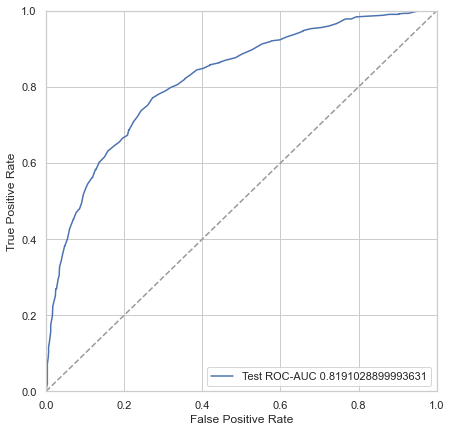

In [336]:
roc_auc_score(y_test, p_pred)
roc_auc_pic(y_test, p_pred)

По сравнению с предыдущим пунктом, использование RandomForest немного улучшило качество модели. Метрика теперь составлет около 82% вместо 81. Однако, думаю, что здесь стоит учесть разбиение выборки и случай в улучшении метрики.